In [1]:
seed_value = 123

import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


# Modeling Chilled Water Energy

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [5]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df[['oat', 'orh', 'sat', 'ghi', 'flow', 'cwe']],
                      subsequence=True,
                      period=1,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 61


In [29]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.75
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

#### A different way to merge data

In [6]:
from pandas import concat
def quickmerge(listdf):
    return concat(listdf)


# Create a large initial block 12 months ~ 52 weeks of training and testing data
data_weeks = 52
# 51 weeks training and 1 week of testing
splitvalue =  0.9807
# create list of training, testing arrays
weeklist = []


datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)

X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=['oat','orh', 'sat', 'ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=splitvalue
    )
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })



# Create small blocks of data
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=['oat','orh', 'sat', 'ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=splitvalue
    )
    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 10


In [7]:
for week in weeklist:
    for key,value in week.items():
        print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, value: Year-2018-Week-46
name: X_train, value: (89795, 1, 5)
name: y_train, value: (89795, 1, 1)
name: X_test, value: (1768, 1, 5)
name: y_test, value: (1768, 1, 1)
name: Id, value: Year-2019-Week-46
name: X_train, value: (88622, 1, 5)
name: y_train, value: (88622, 1, 1)
name: X_test, value: (1745, 1, 5)
name: y_test, value: (1745, 1, 1)
name: Id, value: Year-2019-Week-51
name: X_train, value: (87248, 1, 5)
name: y_train, value: (87248, 1, 1)
name: X_test, value: (1718, 1, 5)
name: y_test, value: (1718, 1, 1)
name: Id, value: Year-2019-Week-52
name: X_train, value: (87462, 1, 5)
name: y_train, value: (87462, 1, 1)
name: X_test, value: (1722, 1, 5)
name: y_test, value: (1722, 1, 1)
name: Id, value: Year-2020-Week-1
name: X_train, value: (87888, 1, 5)
name: y_train, value: (87888, 1, 1)
name: X_test, value: (1730, 1, 5)
name: y_test, value: (1730, 1, 1)
name: Id, value: Year-2020-Week-2
name: X_train, value: (87696, 1, 5)
name: y_train, value: (87696, 1, 1)
name: X_test, value:

In [8]:
path = '../results/lstm_cwe_3/'
!rm -rf ../results/lstm_cwe_3

In [9]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [10]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [11]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':3000,
    'retrain_from_layers':2
}

modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        nn_model = mp.lstm_model_transferlearning(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                           densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])
        
        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        nn_model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train, y_train, X_test, y_test, epochs=modelconfig['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Idx=weekdata['Id'])
    
    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False
            
    if reinitialize:  
        for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())
    
    # compile model
    nn_model.model_compile()
    
    # creating early stopping and learning reate changing callbacks
    # nn_model.model_callbacks()

  0%|          | 0/10 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 89795 samples, validate on 1768 samples
Epoch 1/3000
 - 21s - loss: 0.0056 - val_loss: 0.0024
Epoch 2/3000
 - 20s - loss: 0.0034 - val_loss: 0.0016
Epoch 3/3000
 - 20s - loss: 0.0028 - val_loss: 0.0016
Epoch 4/3000
 - 20s - loss: 0.0027 - val_loss: 0.0015
Epoch 5/3000
 - 20s - loss: 0.0026 - val_loss: 0.0015
Epoch 6/3000
 - 20s - loss: 0.0026 - val_loss: 0.0015
Epoch 7/3000
 - 20s - loss: 0.0026 - val_loss: 0.0013
Epoch 8/3000
 - 20s - loss: 0.0026 - val_loss: 0.0013
Epoch 9/3000
 - 20s - loss: 0.0025 - val_loss: 0.0013
Epoch 10/3000
 - 20s - loss: 0.0025 - val_loss: 0.0012
Epoch 11/3000
 - 20s - loss: 0.0031 - val_loss: 0.0029
Epoch 12/3000
 - 20s - loss: 0.0030 - val_loss: 0.0022
Epoch 13/3000
 - 20s - loss: 0.0029 - val_loss: 0.0021
Epoch 14/3000
 - 20s - loss: 0.0029 - val_loss: 0.0021
Epoch 15/3000
 - 20s - loss: 0.0030 - val_loss: 0.0020
Epoch 16/3000
 - 20s - loss: 0.0030 - 

 10%|█         | 1/10 [06:02<54:23, 362.59s/it]

Train on 88622 samples, validate on 1745 samples
Epoch 19/3000
 - 9s - loss: 0.0036 - val_loss: 0.0011
Epoch 20/3000
 - 9s - loss: 0.0025 - val_loss: 0.0011
Epoch 21/3000
 - 9s - loss: 0.0025 - val_loss: 0.0010
Epoch 22/3000
 - 9s - loss: 0.0028 - val_loss: 0.0012
Epoch 23/3000
 - 9s - loss: 0.0028 - val_loss: 0.0012
Epoch 24/3000
 - 9s - loss: 0.0027 - val_loss: 0.0011
Epoch 25/3000
 - 9s - loss: 0.0027 - val_loss: 0.0011
Epoch 26/3000
 - 9s - loss: 0.0036 - val_loss: 0.0024
Epoch 27/3000
 - 9s - loss: 0.0033 - val_loss: 0.0021
Epoch 28/3000
 - 9s - loss: 0.0032 - val_loss: 0.0018
Epoch 29/3000
 - 9s - loss: 0.0032 - val_loss: 0.0017


 20%|██        | 2/10 [07:47<38:02, 285.34s/it]

Train on 87248 samples, validate on 1718 samples
Epoch 30/3000
 - 9s - loss: 0.0029 - val_loss: 0.0015
Epoch 31/3000
 - 9s - loss: 0.0026 - val_loss: 0.0015
Epoch 32/3000
 - 9s - loss: 0.0026 - val_loss: 0.0015
Epoch 33/3000
 - 9s - loss: 0.0027 - val_loss: 7.5958e-04
Epoch 34/3000
 - 9s - loss: 0.0027 - val_loss: 7.5965e-04
Epoch 35/3000
 - 9s - loss: 0.0027 - val_loss: 7.6006e-04
Epoch 36/3000
 - 9s - loss: 0.0027 - val_loss: 7.6051e-04
Epoch 37/3000
 - 9s - loss: 0.0035 - val_loss: 0.0017
Epoch 38/3000
 - 9s - loss: 0.0032 - val_loss: 0.0015
Epoch 39/3000
 - 9s - loss: 0.0032 - val_loss: 0.0014
Epoch 40/3000
 - 9s - loss: 0.0032 - val_loss: 0.0013
Epoch 41/3000
 - 9s - loss: 0.0033 - val_loss: 0.0013


 30%|███       | 3/10 [09:41<27:16, 233.83s/it]

Train on 87462 samples, validate on 1722 samples
Epoch 42/3000
 - 9s - loss: 0.0027 - val_loss: 4.9664e-04
Epoch 43/3000
 - 9s - loss: 0.0026 - val_loss: 5.0279e-04
Epoch 44/3000
 - 9s - loss: 0.0026 - val_loss: 5.1136e-04
Epoch 45/3000
 - 9s - loss: 0.0027 - val_loss: 4.7599e-04
Epoch 46/3000
 - 9s - loss: 0.0027 - val_loss: 4.7618e-04
Epoch 47/3000
 - 9s - loss: 0.0027 - val_loss: 4.7619e-04
Epoch 48/3000
 - 9s - loss: 0.0027 - val_loss: 4.7619e-04
Epoch 49/3000
 - 9s - loss: 0.0035 - val_loss: 0.0020
Epoch 50/3000
 - 9s - loss: 0.0032 - val_loss: 0.0017
Epoch 51/3000
 - 9s - loss: 0.0032 - val_loss: 0.0016
Epoch 52/3000
 - 9s - loss: 0.0032 - val_loss: 0.0015
Epoch 53/3000
 - 9s - loss: 0.0032 - val_loss: 0.0015


 40%|████      | 4/10 [11:34<19:45, 197.63s/it]

Train on 87888 samples, validate on 1730 samples
Epoch 54/3000
 - 9s - loss: 0.0058 - val_loss: 0.0010
Epoch 55/3000
 - 9s - loss: 0.0025 - val_loss: 0.0010
Epoch 56/3000
 - 9s - loss: 0.0025 - val_loss: 0.0010
Epoch 57/3000
 - 9s - loss: 0.0027 - val_loss: 0.0012
Epoch 58/3000
 - 9s - loss: 0.0027 - val_loss: 0.0012
Epoch 59/3000
 - 9s - loss: 0.0027 - val_loss: 0.0012
Epoch 60/3000
 - 9s - loss: 0.0027 - val_loss: 0.0012
Epoch 61/3000
 - 9s - loss: 0.0035 - val_loss: 0.0020
Epoch 62/3000
 - 9s - loss: 0.0032 - val_loss: 0.0021


 50%|█████     | 5/10 [13:01<13:41, 164.30s/it]

Train on 87696 samples, validate on 1726 samples
Epoch 63/3000
 - 9s - loss: 0.0044 - val_loss: 0.0015
Epoch 64/3000
 - 9s - loss: 0.0025 - val_loss: 0.0015
Epoch 65/3000
 - 9s - loss: 0.0025 - val_loss: 0.0015
Epoch 66/3000
 - 9s - loss: 0.0027 - val_loss: 0.0013
Epoch 67/3000
 - 9s - loss: 0.0027 - val_loss: 0.0013
Epoch 68/3000
 - 9s - loss: 0.0027 - val_loss: 0.0013
Epoch 69/3000
 - 9s - loss: 0.0027 - val_loss: 0.0013
Epoch 70/3000
 - 9s - loss: 0.0034 - val_loss: 0.0025
Epoch 71/3000
 - 9s - loss: 0.0031 - val_loss: 0.0025
Epoch 72/3000
 - 9s - loss: 0.0031 - val_loss: 0.0024
Epoch 73/3000
 - 9s - loss: 0.0031 - val_loss: 0.0024
Epoch 74/3000
 - 9s - loss: 0.0032 - val_loss: 0.0024
Epoch 75/3000
 - 9s - loss: 0.0032 - val_loss: 0.0024
Epoch 76/3000
 - 9s - loss: 0.0032 - val_loss: 0.0024
Epoch 77/3000
 - 9s - loss: 0.0032 - val_loss: 0.0024


 60%|██████    | 6/10 [15:22<10:30, 157.60s/it]

Train on 87756 samples, validate on 1728 samples
Epoch 78/3000
 - 10s - loss: 0.0029 - val_loss: 0.0051
Epoch 79/3000
 - 9s - loss: 0.0025 - val_loss: 0.0051
Epoch 80/3000
 - 9s - loss: 0.0025 - val_loss: 0.0050
Epoch 81/3000
 - 9s - loss: 0.0025 - val_loss: 0.0049
Epoch 82/3000
 - 9s - loss: 0.0025 - val_loss: 0.0049
Epoch 83/3000
 - 9s - loss: 0.0027 - val_loss: 0.0043
Epoch 84/3000
 - 9s - loss: 0.0027 - val_loss: 0.0043
Epoch 85/3000
 - 9s - loss: 0.0027 - val_loss: 0.0043
Epoch 86/3000
 - 9s - loss: 0.0027 - val_loss: 0.0043
Epoch 87/3000
 - 9s - loss: 0.0036 - val_loss: 0.0041
Epoch 88/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 89/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 90/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 91/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 92/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 93/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 94/3000
 - 9s - loss: 0.0032 - val_loss: 0.0042
Epoch 95/3000
 - 9s - loss: 0.00

 70%|███████   | 7/10 [18:11<08:02, 160.94s/it]

Train on 86725 samples, validate on 1707 samples
Epoch 96/3000
 - 10s - loss: 0.0033 - val_loss: 0.0033
Epoch 97/3000
 - 9s - loss: 0.0026 - val_loss: 0.0033
Epoch 98/3000
 - 9s - loss: 0.0026 - val_loss: 0.0033
Epoch 99/3000
 - 9s - loss: 0.0027 - val_loss: 0.0033
Epoch 100/3000
 - 9s - loss: 0.0027 - val_loss: 0.0033
Epoch 101/3000
 - 9s - loss: 0.0027 - val_loss: 0.0033
Epoch 102/3000
 - 9s - loss: 0.0027 - val_loss: 0.0033
Epoch 103/3000
 - 9s - loss: 0.0035 - val_loss: 0.0029
Epoch 104/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 105/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 106/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 107/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 108/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 109/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 110/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029
Epoch 111/3000
 - 9s - loss: 0.0032 - val_loss: 0.0029


 80%|████████  | 8/10 [20:42<05:16, 158.03s/it]

Train on 86903 samples, validate on 1711 samples
Epoch 112/3000
 - 10s - loss: 0.0027 - val_loss: 0.0026
Epoch 113/3000
 - 9s - loss: 0.0026 - val_loss: 0.0025
Epoch 114/3000
 - 9s - loss: 0.0025 - val_loss: 0.0025
Epoch 115/3000
 - 9s - loss: 0.0027 - val_loss: 0.0015
Epoch 116/3000
 - 9s - loss: 0.0027 - val_loss: 0.0015
Epoch 117/3000
 - 9s - loss: 0.0027 - val_loss: 0.0015
Epoch 118/3000
 - 9s - loss: 0.0027 - val_loss: 0.0015
Epoch 119/3000
 - 9s - loss: 0.0034 - val_loss: 0.0011
Epoch 120/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012
Epoch 121/3000
 - 9s - loss: 0.0031 - val_loss: 0.0012
Epoch 122/3000
 - 9s - loss: 0.0031 - val_loss: 0.0012
Epoch 123/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012
Epoch 124/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012
Epoch 125/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012
Epoch 126/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012
Epoch 127/3000
 - 9s - loss: 0.0032 - val_loss: 0.0012


 90%|█████████ | 9/10 [23:13<02:35, 155.81s/it]

Train on 86949 samples, validate on 1712 samples
Epoch 128/3000
 - 10s - loss: 0.0065 - val_loss: 0.0020
Epoch 129/3000
 - 9s - loss: 0.0025 - val_loss: 0.0020
Epoch 130/3000
 - 9s - loss: 0.0025 - val_loss: 0.0020
Epoch 131/3000
 - 9s - loss: 0.0028 - val_loss: 0.0022
Epoch 132/3000
 - 9s - loss: 0.0028 - val_loss: 0.0022
Epoch 133/3000
 - 9s - loss: 0.0028 - val_loss: 0.0022
Epoch 134/3000
 - 9s - loss: 0.0028 - val_loss: 0.0022
Epoch 135/3000
 - 9s - loss: 0.0035 - val_loss: 0.0024
Epoch 136/3000
 - 9s - loss: 0.0032 - val_loss: 0.0025


100%|██████████| 10/10 [24:43<00:00, 148.37s/it]


In [14]:
path = '../results/lstm_cwe_3/'
modelconfig = {
    'lstm_hidden_units': 16,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':3000,
    'retrain_from_layers':2
}

Name of the file:  ../results/lstm_cwe_3/5min Results_File.txt


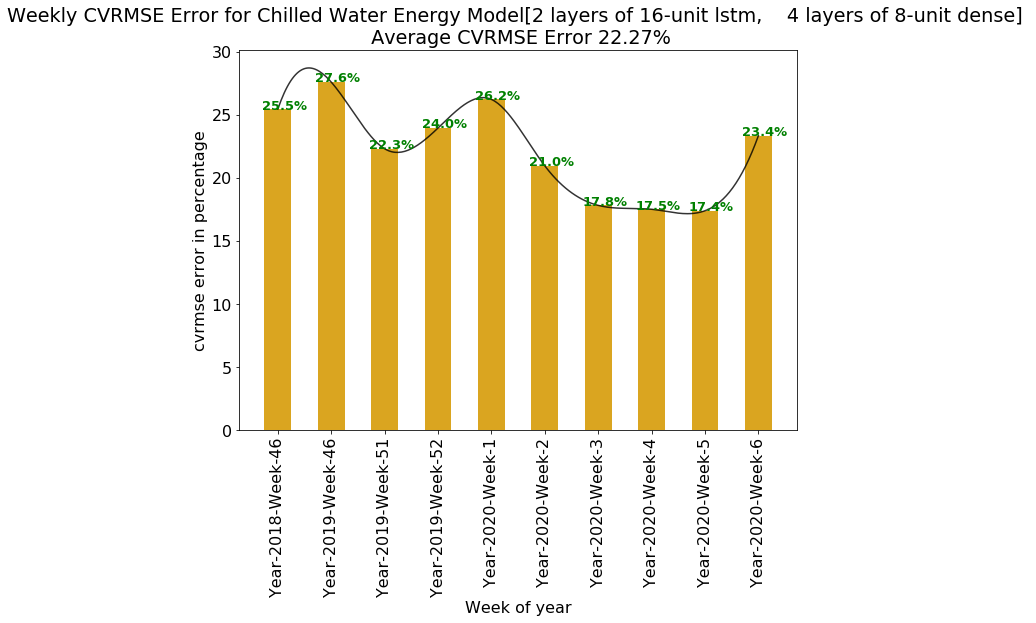

In [16]:
# Open a file
fo = open(path + "5min Results_File.txt", "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Train']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title= 'Weekly CVRMSE Error for Chilled Water Energy Model[{0:} layers of {1:}-unit lstm,\
    {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)

# Modeling Hot Water Energy

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [5]:
df.shape[0]/2016

51.910714285714285

In [6]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df[['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hwe', 'hw_st']],
                      subsequence=True,
                      period=1,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 61


In [ ]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.85
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

### Custom way to create numpy arrays

In [7]:
from pandas import concat
def quickmerge(listdf):
    return concat(listdf)


# Create a large initial block 12 months ~ 52 weeks of training and testing data
data_weeks = 52
# 51 weeks training and 1 week of testing
splitvalue =  0.9807
# create list of training, testing arrays
weeklist = []


datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)

X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=splitvalue
    )
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })



# Create small blocks of data
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=splitvalue
    )
    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 10


In [8]:
for week in weeklist:
    for key,value in week.items():
        print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, value: Year-2018-Week-46
name: X_train, value: (89795, 1, 6)
name: y_train, value: (89795, 1, 1)
name: X_test, value: (1768, 1, 6)
name: y_test, value: (1768, 1, 1)
name: Id, value: Year-2019-Week-46
name: X_train, value: (88622, 1, 6)
name: y_train, value: (88622, 1, 1)
name: X_test, value: (1745, 1, 6)
name: y_test, value: (1745, 1, 1)
name: Id, value: Year-2019-Week-51
name: X_train, value: (87248, 1, 6)
name: y_train, value: (87248, 1, 1)
name: X_test, value: (1718, 1, 6)
name: y_test, value: (1718, 1, 1)
name: Id, value: Year-2019-Week-52
name: X_train, value: (87462, 1, 6)
name: y_train, value: (87462, 1, 1)
name: X_test, value: (1722, 1, 6)
name: y_test, value: (1722, 1, 1)
name: Id, value: Year-2020-Week-1
name: X_train, value: (87888, 1, 6)
name: y_train, value: (87888, 1, 1)
name: X_test, value: (1730, 1, 6)
name: y_test, value: (1730, 1, 1)
name: Id, value: Year-2020-Week-2
name: X_train, value: (87696, 1, 6)
name: y_train, value: (87696, 1, 1)
name: X_test, value:

### Run from here to rerun training with same data

In [48]:
path = '../results/lstm_hwe_5/'
!rm -rf ../results/lstm_hwe_5

In [49]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [50]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [51]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':3000,
    'retrain_from_layers':2
}

modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        nn_model = mp.lstm_model_transferlearning(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                           densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])
        
        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        nn_model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train, y_train, X_test, y_test, epochs=modelconfig['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Idx=weekdata['Id'])
    
    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False
            
    if reinitialize:  
        for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())
    
    # compile model
    nn_model.model_compile()
    
    # creating early stopping and learning reate changing callbacks
    # nn_model.model_callbacks()

  0%|          | 0/10 [00:00<?, ?it/s]

Train on 89795 samples, validate on 1768 samples
Epoch 1/3000
 - 21s - loss: 0.0264 - val_loss: 0.1075
Epoch 2/3000
 - 20s - loss: 0.0188 - val_loss: 0.0583
Epoch 3/3000
 - 20s - loss: 0.0158 - val_loss: 0.0543
Epoch 4/3000
 - 20s - loss: 0.0155 - val_loss: 0.0493
Epoch 5/3000
 - 20s - loss: 0.0151 - val_loss: 0.0439
Epoch 6/3000
 - 20s - loss: 0.0144 - val_loss: 0.0407
Epoch 7/3000
 - 20s - loss: 0.0139 - val_loss: 0.0363
Epoch 8/3000
 - 20s - loss: 0.0136 - val_loss: 0.0331
Epoch 9/3000
 - 20s - loss: 0.0133 - val_loss: 0.0309
Epoch 10/3000
 - 20s - loss: 0.0129 - val_loss: 0.0267
Epoch 11/3000
 - 20s - loss: 0.0123 - val_loss: 0.0256
Epoch 12/3000
 - 20s - loss: 0.0124 - val_loss: 0.0252
Epoch 13/3000
 - 20s - loss: 0.0122 - val_loss: 0.0252
Epoch 14/3000
 - 20s - loss: 0.0119 - val_loss: 0.0237
Epoch 15/3000
 - 20s - loss: 0.0117 - val_loss: 0.0212
Epoch 16/3000
 - 20s - loss: 0.0112 - val_loss: 0.0218
Epoch 17/3000
 - 20s - loss: 0.0110 - val_loss: 0.0230
Epoch 18/3000
 - 20s - lo

 10%|█         | 1/10 [17:09<2:34:29, 1029.96s/it]

Train on 88622 samples, validate on 1745 samples
Epoch 52/3000
 - 10s - loss: 0.0107 - val_loss: 0.0119
Epoch 53/3000
 - 9s - loss: 0.0091 - val_loss: 0.0119
Epoch 54/3000
 - 9s - loss: 0.0092 - val_loss: 0.0119
Epoch 55/3000
 - 9s - loss: 0.0087 - val_loss: 0.0122
Epoch 56/3000
 - 9s - loss: 0.0087 - val_loss: 0.0122
Epoch 57/3000
 - 9s - loss: 0.0087 - val_loss: 0.0122
Epoch 58/3000
 - 9s - loss: 0.0087 - val_loss: 0.0122
Epoch 59/3000
 - 9s - loss: 0.0091 - val_loss: 0.0123
Epoch 60/3000
 - 9s - loss: 0.0088 - val_loss: 0.0123
Epoch 61/3000
 - 9s - loss: 0.0088 - val_loss: 0.0123
Epoch 62/3000
 - 9s - loss: 0.0088 - val_loss: 0.0123


 20%|██        | 2/10 [18:58<1:40:27, 753.42s/it] 

Train on 87248 samples, validate on 1718 samples
Epoch 63/3000
 - 10s - loss: 0.0198 - val_loss: 0.0151
Epoch 64/3000
 - 9s - loss: 0.0091 - val_loss: 0.0151
Epoch 65/3000
 - 9s - loss: 0.0091 - val_loss: 0.0150
Epoch 66/3000
 - 9s - loss: 0.0086 - val_loss: 0.0155
Epoch 67/3000
 - 9s - loss: 0.0086 - val_loss: 0.0155
Epoch 68/3000
 - 9s - loss: 0.0086 - val_loss: 0.0155
Epoch 69/3000
 - 9s - loss: 0.0086 - val_loss: 0.0155
Epoch 70/3000
 - 9s - loss: 0.0090 - val_loss: 0.0154
Epoch 71/3000
 - 9s - loss: 0.0087 - val_loss: 0.0154
Epoch 72/3000
 - 9s - loss: 0.0087 - val_loss: 0.0154
Epoch 73/3000
 - 9s - loss: 0.0087 - val_loss: 0.0154


 30%|███       | 3/10 [20:45<1:05:16, 559.48s/it]

Train on 87462 samples, validate on 1722 samples
Epoch 74/3000
 - 10s - loss: 0.0135 - val_loss: 0.0118
Epoch 75/3000
 - 9s - loss: 0.0095 - val_loss: 0.0100
Epoch 76/3000
 - 9s - loss: 0.0095 - val_loss: 0.0084
Epoch 77/3000
 - 9s - loss: 0.0095 - val_loss: 0.0071
Epoch 78/3000
 - 9s - loss: 0.0095 - val_loss: 0.0062
Epoch 79/3000
 - 9s - loss: 0.0095 - val_loss: 0.0056
Epoch 80/3000
 - 9s - loss: 0.0095 - val_loss: 0.0049
Epoch 81/3000
 - 9s - loss: 0.0095 - val_loss: 0.0047
Epoch 82/3000
 - 9s - loss: 0.0094 - val_loss: 0.0047
Epoch 83/3000
 - 9s - loss: 0.0093 - val_loss: 0.0045
Epoch 84/3000
 - 9s - loss: 0.0094 - val_loss: 0.0047
Epoch 85/3000
 - 9s - loss: 0.0093 - val_loss: 0.0046
Epoch 86/3000
 - 9s - loss: 0.0089 - val_loss: 0.0090
Epoch 87/3000
 - 9s - loss: 0.0089 - val_loss: 0.0089
Epoch 88/3000
 - 9s - loss: 0.0089 - val_loss: 0.0089
Epoch 89/3000
 - 9s - loss: 0.0089 - val_loss: 0.0089
Epoch 90/3000
 - 9s - loss: 0.0094 - val_loss: 0.0067
Epoch 91/3000
 - 9s - loss: 0.00

 40%|████      | 4/10 [23:37<44:19, 443.24s/it]  

Train on 87888 samples, validate on 1730 samples
Epoch 92/3000
 - 10s - loss: 0.0121 - val_loss: 0.0028
Epoch 93/3000
 - 9s - loss: 0.0093 - val_loss: 0.0030
Epoch 94/3000
 - 9s - loss: 0.0093 - val_loss: 0.0032
Epoch 95/3000
 - 9s - loss: 0.0090 - val_loss: 0.0082
Epoch 96/3000
 - 9s - loss: 0.0088 - val_loss: 0.0087
Epoch 97/3000
 - 9s - loss: 0.0088 - val_loss: 0.0088
Epoch 98/3000
 - 9s - loss: 0.0088 - val_loss: 0.0088
Epoch 99/3000
 - 9s - loss: 0.0088 - val_loss: 0.0093
Epoch 100/3000
 - 9s - loss: 0.0089 - val_loss: 0.0093


 50%|█████     | 5/10 [25:07<28:07, 337.47s/it]

Train on 87696 samples, validate on 1726 samples
Epoch 101/3000
 - 10s - loss: 0.0150 - val_loss: 0.0025
Epoch 102/3000
 - 9s - loss: 0.0093 - val_loss: 0.0025
Epoch 103/3000
 - 9s - loss: 0.0093 - val_loss: 0.0025
Epoch 104/3000
 - 9s - loss: 0.0093 - val_loss: 0.0064
Epoch 105/3000
 - 9s - loss: 0.0088 - val_loss: 0.0067
Epoch 106/3000
 - 9s - loss: 0.0088 - val_loss: 0.0067
Epoch 107/3000
 - 9s - loss: 0.0088 - val_loss: 0.0067
Epoch 108/3000
 - 9s - loss: 0.0089 - val_loss: 0.0093
Epoch 109/3000
 - 9s - loss: 0.0089 - val_loss: 0.0095


 60%|██████    | 6/10 [26:38<17:33, 263.39s/it]

Train on 87756 samples, validate on 1728 samples
Epoch 110/3000
 - 10s - loss: 0.0126 - val_loss: 0.0053
Epoch 111/3000
 - 9s - loss: 0.0092 - val_loss: 0.0057
Epoch 112/3000
 - 9s - loss: 0.0092 - val_loss: 0.0062
Epoch 113/3000
 - 9s - loss: 0.0094 - val_loss: 0.0044
Epoch 114/3000
 - 9s - loss: 0.0088 - val_loss: 0.0045
Epoch 115/3000
 - 9s - loss: 0.0088 - val_loss: 0.0046
Epoch 116/3000
 - 9s - loss: 0.0088 - val_loss: 0.0045
Epoch 117/3000
 - 9s - loss: 0.0091 - val_loss: 0.0026
Epoch 118/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 119/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 120/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 121/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 122/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 123/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 124/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 125/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 126/3000
 - 9s - loss: 0.0090 - val_loss: 0.0026
Epoch 127/3000


 70%|███████   | 7/10 [29:51<12:06, 242.21s/it]

Train on 86725 samples, validate on 1707 samples
Epoch 130/3000
 - 10s - loss: 0.0127 - val_loss: 0.0196
Epoch 131/3000
 - 9s - loss: 0.0091 - val_loss: 0.0194
Epoch 132/3000
 - 9s - loss: 0.0090 - val_loss: 0.0192
Epoch 133/3000
 - 9s - loss: 0.0090 - val_loss: 0.0192
Epoch 134/3000
 - 9s - loss: 0.0090 - val_loss: 0.0191
Epoch 135/3000
 - 9s - loss: 0.0089 - val_loss: 0.0196
Epoch 136/3000
 - 9s - loss: 0.0089 - val_loss: 0.0195
Epoch 137/3000
 - 9s - loss: 0.0094 - val_loss: 0.0110
Epoch 138/3000
 - 9s - loss: 0.0088 - val_loss: 0.0100
Epoch 139/3000
 - 9s - loss: 0.0088 - val_loss: 0.0099
Epoch 140/3000
 - 9s - loss: 0.0088 - val_loss: 0.0099
Epoch 141/3000
 - 9s - loss: 0.0088 - val_loss: 0.0099
Epoch 142/3000
 - 9s - loss: 0.0089 - val_loss: 0.0088
Epoch 143/3000
 - 9s - loss: 0.0089 - val_loss: 0.0086
Epoch 144/3000
 - 9s - loss: 0.0089 - val_loss: 0.0085
Epoch 145/3000
 - 9s - loss: 0.0089 - val_loss: 0.0085
Epoch 146/3000
 - 9s - loss: 0.0089 - val_loss: 0.0084
Epoch 147/3000


 80%|████████  | 8/10 [33:58<08:07, 243.77s/it]

Train on 86903 samples, validate on 1711 samples
Epoch 156/3000
 - 10s - loss: 0.0121 - val_loss: 0.0043
Epoch 157/3000
 - 9s - loss: 0.0091 - val_loss: 0.0043
Epoch 158/3000
 - 9s - loss: 0.0092 - val_loss: 0.0047
Epoch 159/3000
 - 9s - loss: 0.0089 - val_loss: 0.0076
Epoch 160/3000
 - 9s - loss: 0.0088 - val_loss: 0.0077
Epoch 161/3000
 - 9s - loss: 0.0088 - val_loss: 0.0077
Epoch 162/3000
 - 9s - loss: 0.0088 - val_loss: 0.0077
Epoch 163/3000
 - 9s - loss: 0.0089 - val_loss: 0.0071
Epoch 164/3000
 - 9s - loss: 0.0089 - val_loss: 0.0070
Epoch 165/3000
 - 9s - loss: 0.0089 - val_loss: 0.0070


 90%|█████████ | 9/10 [35:39<03:20, 200.90s/it]

Train on 86949 samples, validate on 1712 samples
Epoch 166/3000
 - 10s - loss: 0.0123 - val_loss: 0.0168
Epoch 167/3000
 - 9s - loss: 0.0055 - val_loss: 0.0167
Epoch 168/3000
 - 9s - loss: 0.0055 - val_loss: 0.0170
Epoch 169/3000
 - 9s - loss: 0.0054 - val_loss: 0.0190
Epoch 170/3000
 - 9s - loss: 0.0055 - val_loss: 0.0191
Epoch 171/3000
 - 9s - loss: 0.0055 - val_loss: 0.0191
Epoch 172/3000
 - 9s - loss: 0.0055 - val_loss: 0.0191
Epoch 173/3000
 - 9s - loss: 0.0058 - val_loss: 0.0188
Epoch 174/3000
 - 9s - loss: 0.0057 - val_loss: 0.0186
Epoch 175/3000
 - 9s - loss: 0.0057 - val_loss: 0.0184


100%|██████████| 10/10 [37:20<00:00, 224.08s/it]


In [9]:
path = '../results/lstm_hwe_4/'
modelconfig = {
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':3000,
    'retrain_from_layers':2
}

Name of the file:  ../results/lstm_hwe_4/5min Results_File.txt


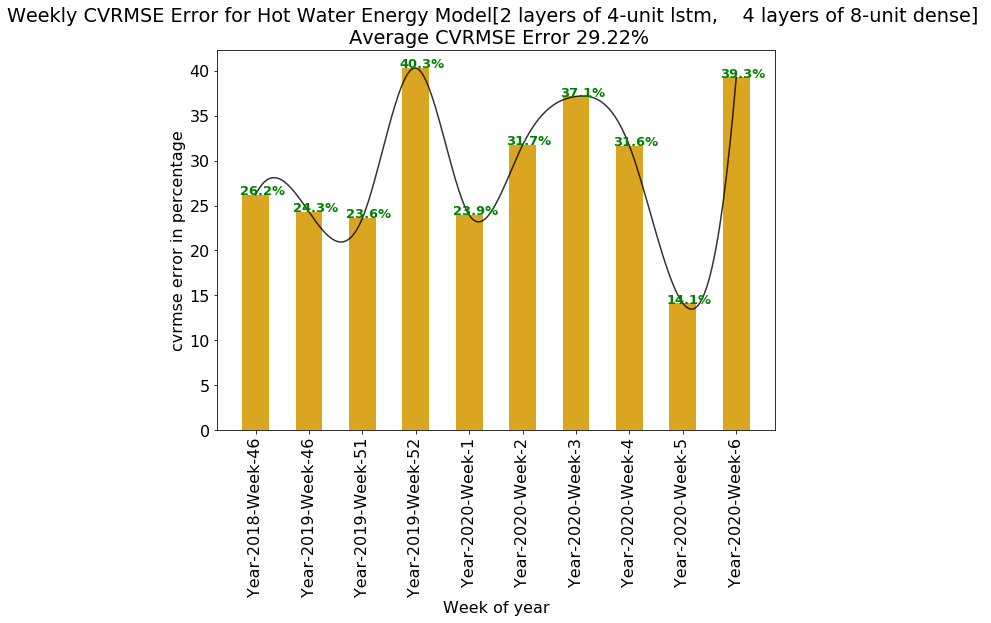

In [20]:
# Open a file
fo = open(path + "5min Results_File.txt", "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title= 'Weekly CVRMSE Error for Hot Water Energy Model[{0:} layers of {1:}-unit lstm,\
    {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

In [ ]:
# Check the trainable status of the individual layers
for layer in nn_model.model.layers:
    print(layer, layer.trainable, layer.name)

In [ ]:
#model.model.summary()

#nn_model.model.layers[-1].input_shape

#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())

#nn_model.model.layers[-1].output_shape